## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


---
## 1. Compute the camera calibration using chessboard images

First step in calculating camera matrix is using chessboard to acquire image points and obejct points

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

# Chess board size
chessboard_size = (9, 6)

# Since we know object points, we can prepare them as (0, 0, 0), (1, 0, 0) ...
objp = np.zeros((chessboard_size[1] * chessboard_size[0], 3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Prepare input arrays for cv2.calibrateCamera()
object_points = []
image_points = []

# Load all images from camera_cal folder
images = glob.glob('camera_cal/calibration*.jpg')

# Iterate through images and append image points for coresponding
for image in images:
    # Read image
    img = cv2.imread(image)

    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Find chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, chessboard_size, None)

    # Check if found corners successfuly
    if ret is True:
        # Append detected corners alongisde coresponding objp
        object_points.append(objp)
        image_points.append(corners)

        # Display found corners as sanity check
        cv2.drawChessboardCorners(img, chessboard_size, corners, ret)
        cv2.imshow('Corners', img)
        cv2.waitKey(200)
        cv2.destroyAllWindows()
    else:
        # Opencv findChessboardCorners fails for for calibration images 1, 4, 5
        # I guess the reason is missing whitespace around chessboard in those images
        
        # Note from opencv site:

        '''
        The function requires white space (like a square-thick border, the wider the better) around the board to make the detection more robust in various 
        environments. Otherwise, if there is no border and the background is dark, the outer black squares cannot be segmented properly and so the square 
        grouping and ordering algorithm fails.
        '''
        print("Failed to find chessbpard corners for", image)


Failed to find chessbpard corners for camera_cal/calibration4.jpg
Failed to find chessbpard corners for camera_cal/calibration5.jpg
Failed to find chessbpard corners for camera_cal/calibration1.jpg


After determining image points for coresponding object points, we can do the actual camera calibration and undistort image where finding of chessboard corners failed (camera_cal/calibration1.jpg)

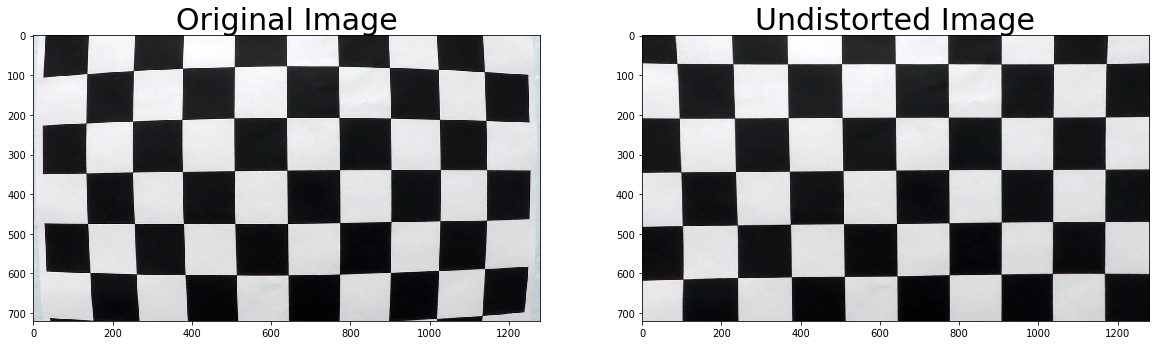

In [2]:
# Image to undistort
distorted_image = cv2.imread('camera_cal/calibration1.jpg')

# Acquire camera matrix and distortion coeffs
ret, mtx, dist_coef, rvecs, tvecs = cv2.calibrateCamera(object_points, image_points, (distorted_image.shape[1], distorted_image.shape[0]), None, None)

# Aplly undistortion on image
undistorted_image = cv2.undistort(distorted_image, mtx, dist_coef, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(distorted_image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistorted_image)
ax2.set_title('Undistorted Image', fontsize=30)
plt.savefig('output_images/undistort_output.jpg')


We can also save camera matrix and distortion coeffs for later usage

In [3]:
import pickle

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist_coef
pickle.dump(dist_pickle, open("calibration_output/wide_dist_pickle.p", "wb"))

## 2. Undistort raw image

After calibrating camera, we can proceed with undistorting raw frames as first step in our image processing pipeline.

First define function which will be used in pipeline:

In [9]:
def undistort_image(image, camera_matrix, distortion_coefficients):
    # Just apply opencv distortion
    return cv2.undistort(image, camera_matrix, distortion_coefficients, None, camera_matrix)

And after that test defined function

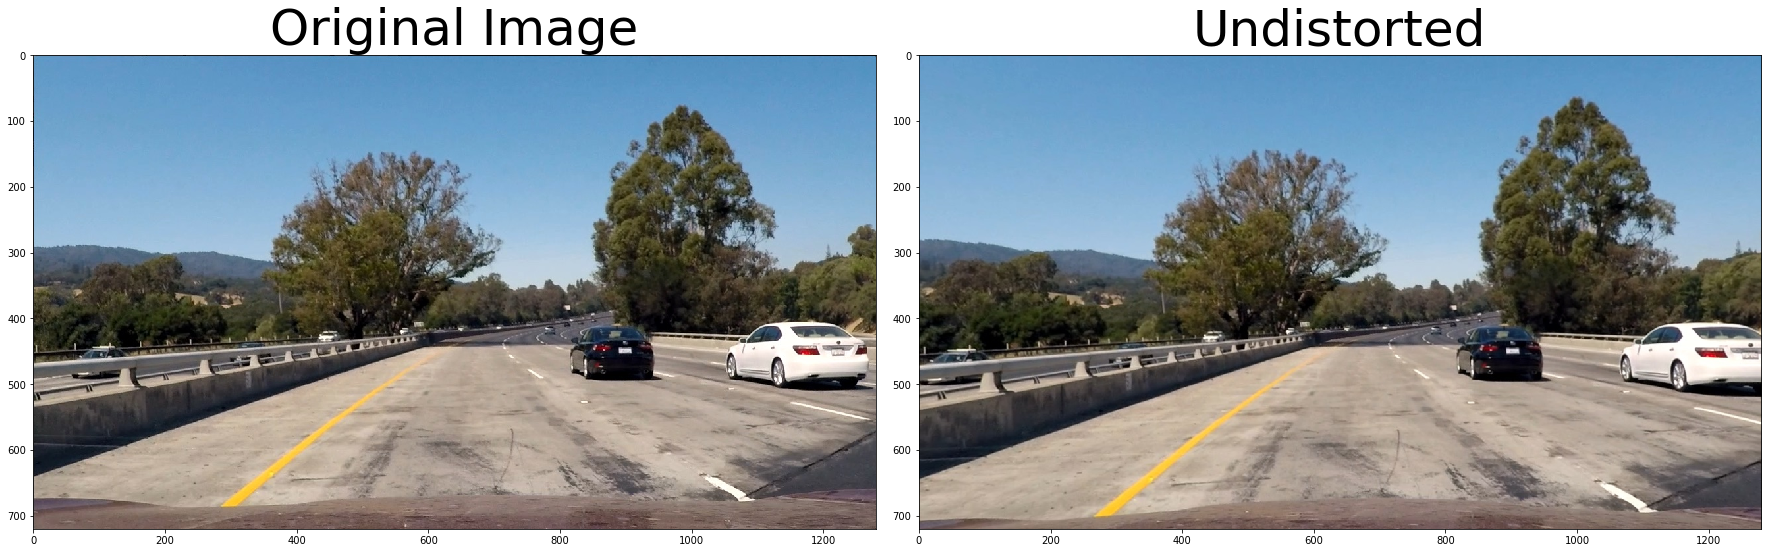

In [14]:
# Test for undistort_image function
image = cv2.imread('test_images/test1.jpg')

# Load saved distortion coefficients and camera matrix
dist_pickle = pickle.load(open("calibration_output/wide_dist_pickle.p", "rb" ))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

undistorted_image = undistort_image(image, mtx, dist)

# Dispaly output
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(cv2.cvtColor(undistorted_image, cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## 3. Use color and gradients thresholding to create a thresholded binary image

Start by defining set of useful functions. 
Sobel in X direction + HLS S channel thresholding could prove to be quite good fit

In [275]:
def absolute_sobel_thresholding(img, thresh_low = 20, thresh_high = 150, kernel_size = 15):
    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Apply sobel in x direction
    sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = kernel_size)

    # Absolute value
    absolute_sobel = np.abs(sobel)

    # Scale absolute to 0 - 255 range
    scaled_absolute = np.uint8(255 * absolute_sobel / np.max(absolute_sobel))

    # Prepare output
    binary_output = np.zeros_like(scaled_absolute)

    # Calculate output
    binary_output[(scaled_absolute > thresh_low) & (scaled_absolute < thresh_high)] = 1

    return binary_output

def color_thresholding(img, thresh_low = 170, thresh_high = 255):
    # Convert image to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

    # Isolate S channel
    s_channel = hls[:, :, 2]

    # Calculate binary output
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh_low) & (s_channel <= thresh_high)] = 1

    return binary_output

def gradient_direction_thresholding(img, sobel_kernel=5, thresh=(0, np.pi/2)):

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Get gradient in x direction
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)

    # Get gradient in y direction
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)

    # Get absolute values for each image
    abs_sobel_x = np.abs(sobel_x)
    abs_sobel_y = np.abs(sobel_y)

    # Calculate gradient direction
    gradient_direction = np.arctan2(abs_sobel_y, abs_sobel_x)

    # Prepare output
    binary_output = np.zeros_like(gradient_direction)

    # Do the thresholding
    l_thresh, h_thresh = thresh
    binary_output[(gradient_direction >= l_thresh) & (gradient_direction <= h_thresh)] = 1

    return binary_output

# Will not be used since it introduces additional y direction edges
def gradient_magnitude_thresholding(img, sobel_kernel=5, mag_thresh=(0, 255)):

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Get gradient in x direction
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)

    # Get gradient in y direction
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)

    # Calculate magnitude as mag = sqrt(sobel_x^2 + sobel_y^2)
    magnitude = np.sqrt(np.square(sobel_x) + np.square(sobel_y))

    # Scale the magnitude to 0 - 255 range
    scaled_magniuted = np.uint8(255 * magnitude / np.max(magnitude))

    # Create binary mask
    binary_output = np.zeros_like(scaled_magniuted)

    low_thresh, high_thresh = mag_thresh

    # Do the thresholding
    binary_output[(low_thresh <= scaled_magniuted) & (scaled_magniuted <= high_thresh)] = 1

    return binary_output

def apply_thresholds(img):
    # Sobel gradient thresholding
    gradient_binary = absolute_sobel_thresholding(img)

    # S channel thresholding
    color_binary = color_thresholding(img)

    # Do not apply magnitude because it introduces y edges we don't want  
    # mag_binary = gradient_magnitude_thresholding(img, sobel_kernel = 5, mag_thresh = (30, 100))
    direction_binary = gradient_direction_thresholding(img, sobel_kernel = 15, thresh = (0.7, 1.4))

    # Prepare binary output
    combined_binary = np.zeros_like(gradient_binary)

    # Combine thresholds
    combined_binary[((gradient_binary == 1) & (direction_binary == 1)) | (color_binary == 1)] = 1

    return combined_binary


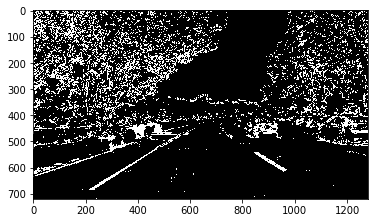

In [276]:
# Test set of thresholding functions
image = cv2.imread('test_images/test5.jpg')

binary_image = apply_thresholds(image)

plt.imshow(binary_image, cmap = 'gray')

## 4. Apply a perspective transform to rectify binary image ("birds-eye view")

First define set of useful functions

In [277]:
def go_to_birdview_perspective(img):
    # Start by defining source points
    # Magic numbers acquired from gimp
    point1 = [280, 700]
    point2 = [595, 460]
    point3 = [725, 460]
    point4 = [1125, 700]
    source = np.float32([point1, point2, point3, point4])

    offset = 100

    # Define destination vertices
    # Magic numbers acquired from gimp
    dest_point1 = [250, 720]
    dest_point2 = [250, 0]
    dest_point3 = [1065, 0]
    dest_point4 = [1065, 720]
    destination = np.float32([dest_point1, dest_point2, dest_point3, dest_point4])

    transformation_matrix = cv2.getPerspectiveTransform(source, destination)
    inverse_transform_matrix = cv2.getPerspectiveTransform(destination, source)

    output = cv2.warpPerspective(img, transformation_matrix, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)

    return output, inverse_transform_matrix

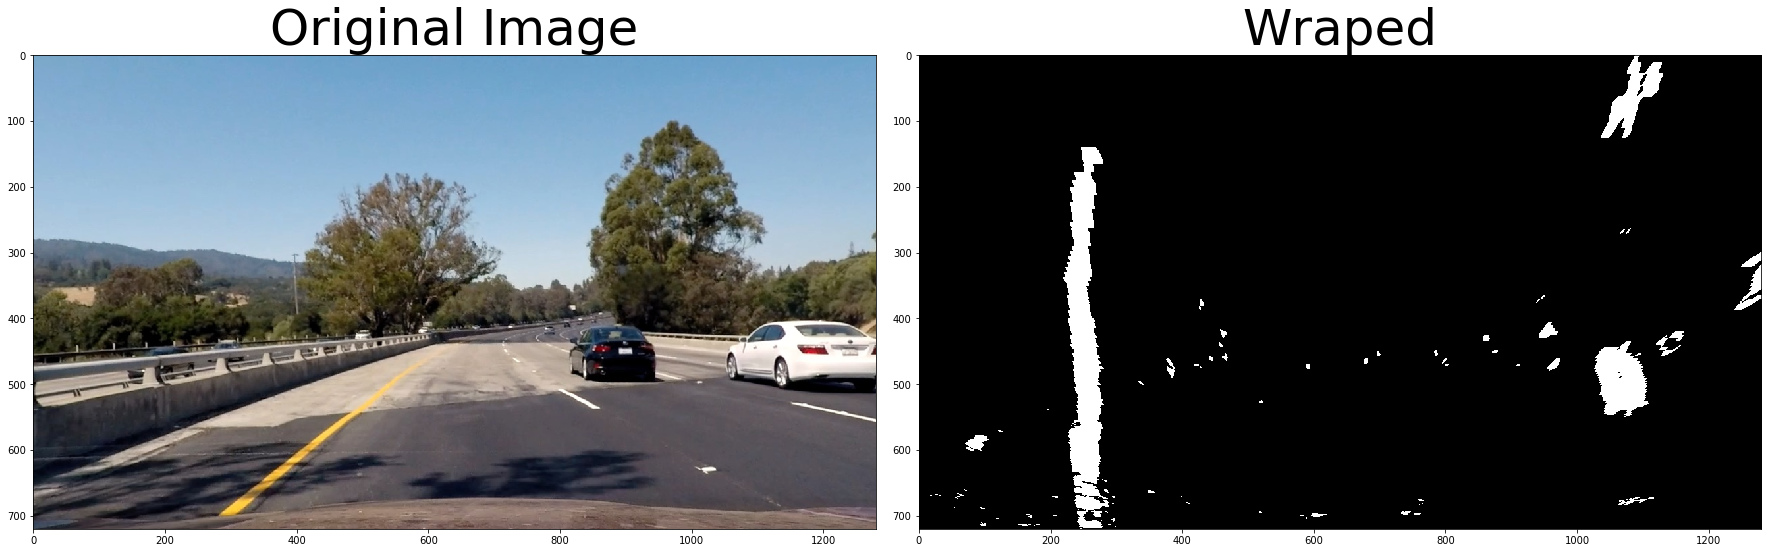

In [280]:
# Test functionality of perspective change
image = cv2.imread('test_images/test4.jpg')

# Undistort image
undistorted_image = undistort_image(image, mtx, dist)

# Convert image to binary
binary_image = apply_thresholds(undistorted_image)

# Change perspective
wraped_image, invers_transform_mat = go_to_birdview_perspective(binary_image)


# Dispaly output
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(undistorted_image, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(wraped_image, cmap = 'gray')
ax2.set_title('Wraped', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)